In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import brier_score_loss

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.utils import shuffle

In [3]:
# pip install binarytree

In [4]:
# pip install bracketeer

In [5]:
from bracketeer import build_bracket

In [17]:
df_seeds = pd.read_csv('Data/mens-machine-learning-competition-2019/DataFiles/NCAATourneySeeds.csv')
df_tour = pd.read_csv('Data/mens-machine-learning-competition-2019/DataFiles/NCAATourneyCompactResults.csv')

In [3]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [4]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [5]:
def seed_to_int(seed):
    #Get just the digits from the seeding. Return as int
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label
df_seeds.head()

,Season,TeamID,seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [6]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


In [7]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


In [8]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [9]:
df_wins

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1
...,...,...
2179,-1,1
2180,-2,1
2181,-8,1
2182,0,1


In [10]:
df_losses

,SeedDiff,Result
0,-1,0
1,-5,0
2,15,0
3,-1,0
4,11,0
...,...,...
2179,1,0
2180,2,0
2181,8,0
2182,0,0


In [11]:
df_predictions['Result'].value_counts()

1    2184
0    2184
Name: Result, dtype: int64

In [12]:
X_train = df_predictions.SeedDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

In [13]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5549, with best C: 0.01


Text(0, 0.5, 'P(Team1 will win)')

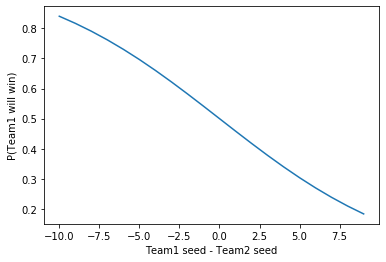

In [14]:
X = np.arange(-10, 10).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [15]:
df_sample_sub = pd.read_csv('SampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in ID.split('_'))

In [16]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [17]:
preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2014_1107_1110,0.458571
1,2014_1107_1112,0.076459
2,2014_1107_1113,0.269613
3,2014_1107_1124,0.159631
4,2014_1107_1140,0.269613


In [18]:
df_sample_sub.to_csv('logreg_seed_starter.csv', index=False)

In [19]:
df_sample_sub

,ID,Pred
0,2014_1107_1110,0.458571
1,2014_1107_1112,0.076459
2,2014_1107_1113,0.269613
3,2014_1107_1124,0.159631
4,2014_1107_1140,0.269613
...,...,...
11385,2018_1452_1460,0.816809
11386,2018_1452_1462,0.339754
11387,2018_1455_1460,0.840369
11388,2018_1455_1462,0.377942


In [15]:
from bracketeer import build_bracket

In [16]:
# m = build_bracket(outputPath = 'bracket.png', 
#                   teamsPath = 'mens-machine-learning-competition-2019/DataFiles/Teams.csv', 
#                   seedsPath = 'mens-machine-learning-competition-2019/DataFiles/NCAATourneySeeds.csv', 
#                   submissionPath = 'SampleSubmissionStage2.csv', 
#                   slotsPath = 'mens-machine-learning-competition-2019/DataFiles/NCAATourneySlots.csv', 
#                   year = 2019)